In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dữ liệu (giả sử bạn đã có sẵn df)
df = pd.read_csv("/kaggle/input/data-full-features-ai/weather_data_nghean (1).csv")

# Kiểm tra thông tin tổng quát
print(df.info())
print(df.describe())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388493 entries, 0 to 388492
Data columns (total 38 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   x         388493 non-null  float64
 1   y         388493 non-null  float64
 2   B04B      388493 non-null  float64
 3   B05B      388493 non-null  float64
 4   B06B      388493 non-null  float64
 5   B09B      388493 non-null  float64
 6   B10B      388493 non-null  float64
 7   B11B      388493 non-null  float64
 8   B12B      388493 non-null  float64
 9   B14B      388493 non-null  float64
 10  B16B      388493 non-null  float64
 11  I2B       388493 non-null  float64
 12  I4B       388493 non-null  float64
 13  IRB       388493 non-null  float64
 14  VSB       388493 non-null  float64
 15  WVB       388493 non-null  float64
 16  CAPE      388493 non-null  float64
 17  CIN       388493 non-null  float64
 18  EWSS      388493 non-null  float64
 19  IE        388493 non-null  float64
 20  ISOR

,x,y,B04B,B05B,B06B,B09B,B10B,B11B,B12B,B14B,...,SSHF,TCLW,TCW,TCWV,U250,U850,V250,V850,Radar,datetime
0,104.90,19.96,0.498362,0.352224,0.236776,255.42627,260.79110,279.25586,259.7476,281.53525,...,-137404.0,0.601746,35.615920,35.005510,25.895142,-4.906418,6.482254,5.172928,0.0,2019-04-01 08:00:00
1,104.94,19.96,0.498362,0.352224,0.236776,255.42627,260.79110,279.25586,259.7476,281.53525,...,-137404.0,0.601746,35.615920,35.005510,25.895142,-4.906418,6.482254,5.172928,0.0,2019-04-01 08:00:00
2,104.98,19.96,0.572723,0.384196,0.249166,255.30000,260.90370,280.62646,260.5460,283.24900,...,-137404.0,0.601746,35.615920,35.005510,25.895142,-4.906418,6.482254,5.172928,0.0,2019-04-01 08:00:00
3,104.86,19.92,0.532949,0.360718,0.238078,255.81377,260.79684,278.82367,259.3540,280.84116,...,-272124.0,0.550171,32.744827,32.179337,26.195923,-4.334152,6.599442,3.686600,0.0,2019-04-01 08:00:00
4,104.90,19.92,0.532949,0.360718,0.238078,255.81377,260.79684,278.82367,259.3540,280.84116,...,-137404.0,0.601746,35.615920,35.005510,25.895142,-4.906418,6.482254,5.172928,0.0,2019-04-01 08:00:00


In [9]:
HIMA_BANDS = ['B04B', 'B05B', 'B06B', 'B09B', 'B10B', 'B11B', 'B12B', 'B14B', 'B16B', 'I2B', 'I4B', 'IRB', 'VSB', 'WVB']
ERA5_PARAMS = ['CAPE', 'CIN', 'EWSS', 'IE', 'ISOR', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SLHF', 'SLOR', 'SSHF', 'TCLW', 'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850']
HEIGHT, WIDTH = 90, 250

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import xgboost as xgb
import lightgbm as lgb
from cuml.ensemble import RandomForestRegressor

#========== Các hàm tiện ích chung ==========
def filter_features(X, selected_features, feature_names=None):
    if isinstance(X, pd.DataFrame):
        missing = set(selected_features) - set(X.columns)
        if missing:
            raise ValueError(f"Missing features: {missing}")
        return X[selected_features]
    elif isinstance(X, np.ndarray):
        if feature_names is None:
            raise ValueError("Feature names chưa được định nghĩa cho numpy array")
        X_df = pd.DataFrame(X, columns=feature_names)
        return X_df[selected_features].values
    else:
        raise TypeError("Đầu vào phải là DataFrame hoặc numpy array")

#========== Hàm cho XGBoost ==========
def train_xgb(X, y, selected_features, params=None, sample_weight=None, n_splits=5):
    default_params = {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "device": "cuda",
        "n_estimators": 100,
        "learning_rate": 0.1,
        "max_depth": 6,
        "subsample": 1.0,
        "colsample_bytree": 1.0,
        "random_state": 42,
        "min_child_weight": 3,
        "gamma": 0
    }
    final_params = {**default_params, **(params or {})}
    
    feature_names = X.columns.tolist() if isinstance(X, pd.DataFrame) else None
    X_filtered = filter_features(X, selected_features, feature_names)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_idx, val_idx = next(kf.split(X_filtered))
    
    # Trích xuất trọng số cho tập train
    if sample_weight is not None:
        train_weight = sample_weight[train_idx]
        val_weight = sample_weight[val_idx]
    else:
        train_weight = val_weight = None

    X_train = X_filtered.iloc[train_idx] if isinstance(X, pd.DataFrame) else X_filtered[train_idx]
    y_train = y.iloc[train_idx] if isinstance(y, pd.Series) else y[train_idx]
    X_val = X_filtered.iloc[val_idx] if isinstance(X, pd.DataFrame) else X_filtered[val_idx]
    y_val = y.iloc[val_idx] if isinstance(y, pd.Series) else y[val_idx]

    model = xgb.XGBRegressor(**final_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        sample_weight=train_weight,  # Thêm trọng số
        early_stopping_rounds=10,
        verbose=False
    )
    
    return {
        'model': model,
        'feature_names': feature_names,
        'selected_features': selected_features
    }


def predict_xgb(model_dict, X):
    X_filtered = filter_features(
        X, 
        model_dict['selected_features'], 
        model_dict['feature_names']
    )
    return model_dict['model'].predict(X_filtered)

#========== Hàm cho LightGBM ==========
def train_lgb(X, y, selected_features, params=None, n_splits=5):
    default_params = {
        'objective': 'regression',
        'metric': 'mse',
        'boosting_type': 'gbdt',
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 6,
        'num_leaves': 31,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'device': 'gpu'
    }
    final_params = {**default_params, **(params or {})}
    
    feature_names = X.columns.tolist() if isinstance(X, pd.DataFrame) else None
    X_filtered = filter_features(X, selected_features, feature_names)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_idx, val_idx = next(kf.split(X_filtered))
    
    X_train = X_filtered.iloc[train_idx] if isinstance(X, pd.DataFrame) else X_filtered[train_idx]
    y_train = y.iloc[train_idx] if isinstance(y, pd.Series) else y[train_idx]
    X_val = X_filtered.iloc[val_idx] if isinstance(X, pd.DataFrame) else X_filtered[val_idx]
    y_val = y.iloc[val_idx] if isinstance(y, pd.Series) else y[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    model = lgb.train(
        final_params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=100,
        callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
    )
    
    return {
        'model': model,
        'feature_names': feature_names,
        'selected_features': selected_features
    }

def predict_lgb(model_dict, X):
    X_filtered = filter_features(
        X,
        model_dict['selected_features'],
        model_dict['feature_names']
    )
    return model_dict['model'].predict(X_filtered)

#========== Hàm cho Random Forest ==========
def train_ert(X, y, selected_features, params=None):
    default_params = {'n_estimators': 100, 'max_features': 1.0, 'n_streams': 1}
    final_params = {**default_params, **(params or {})}
    
    feature_names = X.columns.tolist() if isinstance(X, pd.DataFrame) else None
    X_filtered = filter_features(X, selected_features, feature_names)
    
    model = RandomForestRegressor(**final_params)
    model.fit(X_filtered, y)
    
    return {
        'model': model,
        'feature_names': feature_names,
        'selected_features': selected_features
    }

def predict_ert(model_dict, X):
    X_filtered = filter_features(
        X,
        model_dict['selected_features'],
        model_dict['feature_names']
    )
    return model_dict['model'].predict(X_filtered)

#========== Hàm cho Stacking ==========
def generate_meta_features(X, y, base_models, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    meta = np.zeros((X.shape[0], len(base_models)))
    
    for i, model_dict in enumerate(base_models):
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train = y[train_idx]
            
            if 'xgb' in model_dict['type']:
                m = train_xgb(
                    pd.DataFrame(X_train, columns=model_dict['feature_names']),
                    y_train,
                    model_dict['selected_features'],
                    params=model_dict.get('params', None)
                )
                preds = predict_xgb(m, pd.DataFrame(X_val, columns=model_dict['feature_names']))
            elif 'lgb' in model_dict['type']:
                m = train_lgb(
                    pd.DataFrame(X_train, columns=model_dict['feature_names']),
                    y_train,
                    model_dict['selected_features'],
                    params=model_dict.get('params', None)
                )
                preds = predict_lgb(m, pd.DataFrame(X_val, columns=model_dict['feature_names']))
            elif 'ert' in model_dict['type']:
                m = train_ert(
                    pd.DataFrame(X_train, columns=model_dict['feature_names']),
                    y_train,
                    model_dict['selected_features'],
                    params=model_dict.get('params', None)
                )
                preds = predict_ert(m, pd.DataFrame(X_val, columns=model_dict['feature_names']))
            
            meta[val_idx, i] = preds
            
    return meta

def train_stacking(X, y, base_models, level2_model, n_folds=5):
    meta_features = generate_meta_features(X.values, y.values, base_models, n_folds)
    level2_model.fit(meta_features, y.values)
    return level2_model, [model['feature_names'] for model in base_models]

def predict_stacking(stacking_model, base_models_info, X):
    meta_test = []
    for model_info in base_models_info:
        if model_info['type'] == 'xgb':
            preds = predict_xgb(model_info, X)
        elif model_info['type'] == 'lgb':
            preds = predict_lgb(model_info, X)
        elif model_info['type'] == 'ert':
            preds = predict_ert(model_info, X)
        meta_test.append(preds)
    return stacking_model.predict(np.column_stack(meta_test))

#========== Pipeline chính ==========
# Load data và chuẩn bị features
df = pd.read_csv("/kaggle/input/data-full-features-ai/weather_data_nghean (1).csv")
df.fillna(df.mean(numeric_only=True), inplace=True)

TARGET_COL = "Radar"
HIMA_BANDS = ['B04B', 'B05B', 'B06B', 'B09B', 'B10B', 'B11B', 'B12B', 'B14B', 'B16B', 'I2B', 'I4B', 'IRB', 'VSB', 'WVB']
ERA5_PARAMS = ['CAPE', 'CIN', 'EWSS', 'IE', 'ISOR', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SLHF', 'SLOR', 'SSHF', 'TCLW', 'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850']
FOR_XG = HIMA_BANDS + ERA5_PARAMS
ALL_FEATURES = FOR_XG

X = df[ALL_FEATURES]
y = df[TARGET_COL]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện các model level-1
train_weight = np.where(y_train > 0, 5.0, 1.0)
xgb_model = train_xgb(
    X_train, y_train,
    selected_features=FOR_XG,
    params={'n_estimators': 200, 'max_depth': 6},
    sample_weight=train_weight
)

lgb_model = train_lgb(
    X_train, y_train,
    selected_features=ALL_FEATURES,
    params={'n_estimators': 200, 'max_depth': 6}
)

ert_model = train_ert(
    X_train, y_train,
    selected_features=ALL_FEATURES
)

# Đánh giá các model
def evaluate_model(predict_func, model_dict, X_test, y_test):
    preds = predict_func(model_dict, X_test)
    cc, _ = pearsonr(y_test, preds)  # Tính Pearson Correlation Coefficient
    return {
        'MAE': mean_absolute_error(y_test, preds),
        'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
        'R2': r2_score(y_test, preds),
        'CC': cc
    }

metrics = {
    'XGB': evaluate_model(predict_xgb, xgb_model, X_test, y_test),
    'LGB': evaluate_model(predict_lgb, lgb_model, X_test, y_test),
    'ERT': evaluate_model(predict_ert, ert_model, X_test, y_test)
}

# Huấn luyện stacking model
base_models_info = [
    {'type': 'xgb', **xgb_model},
    {'type': 'lgb', **lgb_model},
    {'type': 'ert', **ert_model}
]

level2_model = ElasticNet(alpha=0.01, l1_ratio=0.7)
stacking_model, feature_names_list = train_stacking(
    X_train, y_train,
    base_models=base_models_info,
    level2_model=level2_model
)

# Dự đoán và đánh giá stacking
test_preds = predict_stacking(
    stacking_model,
    base_models_info,
    X_test
)

stacking_metrics = {
    'MAE': mean_absolute_error(y_test, test_preds),
    'RMSE': np.sqrt(mean_squared_error(y_test, test_preds)),
    'R2': r2_score(y_test, test_preds),
    'CC': pearsonr(y_test, test_preds)[0]  # Tính CC cho stacking
}

print("Level-1 Metrics:", metrics)
print("\nStacking Metrics:", stacking_metrics)

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8240
[LightGBM] [Info] Number of data points in the train set: 248635, number of used features: 34
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 34 dense feature groups (8.54 MB) transferred to GPU in 0.011481 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.206359
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`se

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8240
[LightGBM] [Info] Number of data points in the train set: 198908, number of used features: 34
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 34 dense feature groups (6.83 MB) transferred to GPU in 0.009675 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.206243
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8240
[LightGBM] [Info] Number of data points in the train set: 198908, number of used features: 34
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 34 dense feature

In [11]:
!pip install rasterio
!pip install geopandas

In [12]:
def collect_files(base_path, data_type, expected_subdirs=None):
    files_dict = {}
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.tif'):
                file_path = os.path.join(root, file)
                dt = parse_datetime_from_filename(file, data_type)
                if dt is None:
                    continue
                if expected_subdirs:
                    subdir = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(file_path)))))
                    if dt not in files_dict:
                        files_dict[dt] = {}
                    files_dict[dt][subdir] = file_path
                else:
                    files_dict[dt] = file_path
    return files_dict

In [13]:
# Hàm phân tích thời gian từ tên file
def parse_datetime_from_filename(filename, data_type):
    try:
        if data_type == "Hima":
            parts = filename.split('_')
            if len(parts) < 2:
                return None
            time_part = parts[1].split('_TB.tif')[0]
            time_part = time_part.replace('.Z', '')
            dt = datetime.strptime(time_part, '%Y%m%d%H%M')
        elif data_type == "ERA5":
            parts = filename.split('_')
            if len(parts) < 2:
                return None
            time_part = parts[1].replace('.tif', '')
            dt = datetime.strptime(time_part, '%Y%m%d%H%M%S')
        elif data_type == "Radar":
            time_part = filename.split('_')[1].replace('.tif', '')
            dt = datetime.strptime(time_part, '%Y%m%d%H%M%S')
        else:
            return None
        return dt.replace(minute=0, second=0, microsecond=0)
    except Exception as e:
        global error_count
        if error_count < 5:
            print(f"Error parsing datetime from {filename} (type {data_type}): {e}")
            error_count += 1
        return None
error_count = 0

In [16]:
import os
import rasterio
import geopandas as gpd
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Các hằng số
HEIGHT = 90
WIDTH = 250
BASE_PATH = "/kaggle/input/btl-ai/DATA_SV"
PRECIP_PATH = os.path.join(BASE_PATH, "Precipitation/Radar")
OUTPUT_PATH = "/kaggle/working/maps"
y_pred=predict_stacking(
    stacking_model,
    base_models_info,
    X_train
)
# Hàm thu thập radar file
radar_files_dict = collect_files(PRECIP_PATH, "Radar")

if not radar_files_dict:
    print("⚠️ Không có file radar nào!")
else:
    radar_files_dict = {datetime.strptime(str(k), "%Y-%m-%d %H:%M:%S"): v for k, v in radar_files_dict.items()}
    print("🔍 radar_files_dict keys:", list(radar_files_dict.keys())[:5])

    final_df = pd.read_csv("/kaggle/input/data-full-features-ai/weather_data_nghean (1).csv")
    final_df['datetime'] = pd.to_datetime(final_df['datetime'])

    sample_dt = pd.to_datetime("2020-10-29 06:00:00")
    sample_df = final_df[final_df['datetime'] == sample_dt].copy()

    if sample_df.empty:
        print(f"Không có dữ liệu cho thời điểm {sample_dt}")
    else:
        test_indices = X_test.index
        sample_df['prediction'] = np.nan
        for idx in test_indices:
            if idx in sample_df.index:
                sample_df.loc[idx, 'prediction'] = y_pred[list(test_indices).index(idx)]

        ground_truth_map = np.zeros((HEIGHT, WIDTH))
        prediction_map = np.zeros((HEIGHT, WIDTH))

        if sample_dt in radar_files_dict:
            radar_file = radar_files_dict[sample_dt]
        else:
            if radar_files_dict:
                closest_dt = min(radar_files_dict.keys(), key=lambda x: abs(x - sample_dt))
                radar_file = radar_files_dict[closest_dt]
                print(f"Không tìm thấy {sample_dt}, dùng ngày gần nhất: {closest_dt}")
            else:
                print("⚠️ Không tìm thấy file radar gần nhất.")
                radar_file = None

        if radar_file:
            with rasterio.open(radar_file) as src:
                transform = src.transform
                for _, row in sample_df.iterrows():
                    try:
                        row_idx, col_idx = rasterio.transform.rowcol(transform, row['x'], row['y'])
                        if 0 <= row_idx < HEIGHT and 0 <= col_idx < WIDTH:
                            ground_truth_map[row_idx, col_idx] = row['Radar']
                            if not np.isnan(row['prediction']):
                                prediction_map[row_idx, col_idx] = row['prediction']
                    except Exception as e:
                        print(f"Bỏ qua điểm ({row['x']}, {row['y']}) do lỗi: {e}")

            x_min, x_max = sample_df['x'].min(), sample_df['x'].max()
            y_min, y_max = sample_df['y'].min(), sample_df['y'].max()
            if not np.isfinite([x_min, x_max, y_min, y_max]).all() or x_min == x_max or y_min == y_max:
                print(f"Extent không hợp lệ cho thời điểm {sample_dt}, bỏ qua.")
            else:
                # >>> CHỈNH SỬA Ở ĐÂY: Dùng vmin, vmax chung
                vmin = min(ground_truth_map.min(), prediction_map.min())
                vmax = max(ground_truth_map.max(), prediction_map.max())
                print(f"Color range: {vmin} - {vmax}")

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

                ax1.set_title(f'Ground Truth - {sample_dt}')
                ax1.coastlines()
                ax1.add_feature(cfeature.BORDERS)
                im1 = ax1.imshow(ground_truth_map, cmap='Blues', origin='upper', transform=ccrs.PlateCarree(),
                                 extent=(x_min, x_max, y_min, y_max), vmin=vmin, vmax=vmax)
                plt.colorbar(im1, ax=ax1, label='Lượng mưa (mm/h)')

                ax2.set_title(f'Prediction (Stacking) - {sample_dt}')
                ax2.coastlines()
                ax2.add_feature(cfeature.BORDERS)
                im2 = ax2.imshow(prediction_map, cmap='Blues', origin='upper', transform=ccrs.PlateCarree(),
                                 extent=(x_min, x_max, y_min, y_max), vmin=vmin, vmax=vmax)
                plt.colorbar(im2, ax=ax2, label='Lượng mưa (mm/h)')

                plt.tight_layout()
                os.makedirs(OUTPUT_PATH, exist_ok=True)
                plt.savefig(os.path.join(OUTPUT_PATH, f'rainfall_map_{sample_dt.strftime("%Y%m%d%H%M")}.png'))
                plt.close()
                print(f"✅ Đã lưu bản đồ cho thời điểm {sample_dt}")


🔍 radar_files_dict keys: [datetime.datetime(2020, 10, 17, 7, 0), datetime.datetime(2020, 10, 17, 10, 0), datetime.datetime(2020, 10, 17, 4, 0), datetime.datetime(2020, 10, 17, 2, 0), datetime.datetime(2020, 10, 17, 13, 0)]
Color range: -0.030273427096177287 - 82.57
✅ Đã lưu bản đồ cho thời điểm 2020-10-29 06:00:00


In [17]:
# # import shutil
# shutil.rmtree("/kaggle/working/maps")

In [19]:
import matplotlib.pyplot as plt
import numpy as np
OUTPUT_PATH = "/kaggle/working" 
def plot_rainfall_comparison(y_true, y_pred):
    """
    Vẽ biểu đồ so sánh lượng mưa dự đoán và thực tế
    
    Parameters:
    y_true (array): Giá trị thực tế
    y_pred (array): Giá trị dự đoán
    """
    plt.figure(figsize=(8, 8))
    
    # Vẽ scatter plot
    scatter = plt.scatter(y_true, y_pred, c=np.abs(y_true - y_pred), 
                         cmap='viridis', alpha=0.6, edgecolors='w', 
                         linewidth=0.5, vmin=0, vmax=40)
    
    # Vẽ đường y=x
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='y=x')
    
    # Cấu hình plot
    plt.colorbar(scatter, label='Sai số tuyệt đối (mm/h)')
    plt.title('So sánh Ground Truth và Dự đoán Stacking', fontsize=14, pad=20)
    plt.xlabel('Ground Truth (Lượng mưa mm/h)', fontsize=12)
    plt.ylabel('Dự đoán (Lượng mưa mm/h)', fontsize=12)
    plt.xticks(np.arange(0, 85, 20))
    plt.yticks(np.arange(0, 85, 20))
    plt.grid(alpha=0.3)
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.show()
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    plt.savefig(os.path.join(OUTPUT_PATH, 'scatter_comparison.png'))

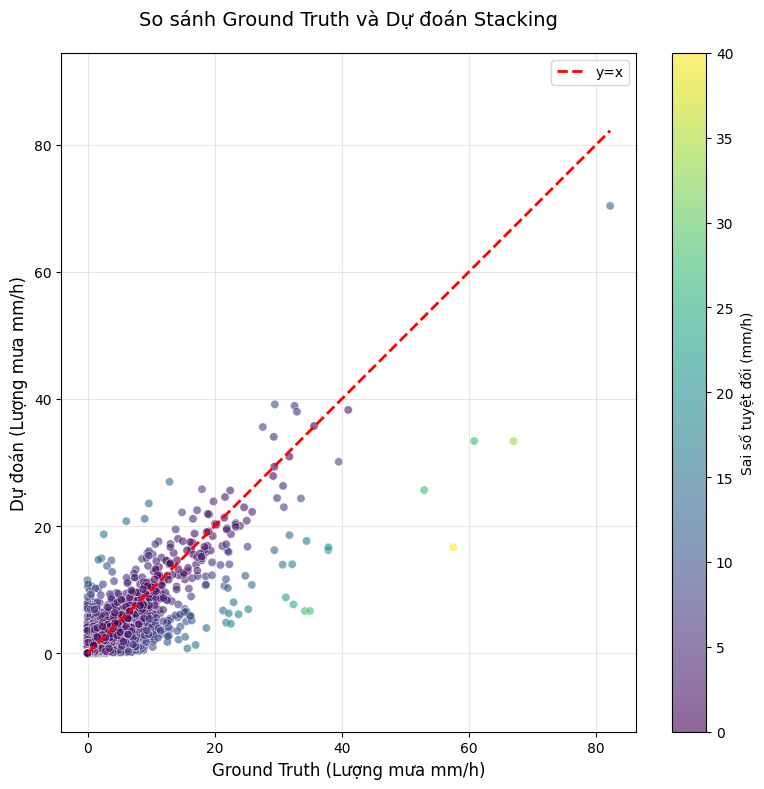

<Figure size 640x480 with 0 Axes>

In [20]:
y_test_pred = predict_stacking(stacking_model, base_models_info, X_test)
plot_rainfall_comparison(y_test, y_test_pred)